In [1]:
import sys
print(sys.version)

3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]


In [2]:
! eups list -s | grep pfs_pipe2d

pfs_pipe2d            w.2022.22  	current setup


In [3]:
"""
Created on May 03 2022
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/tigress/ncaplar/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)

In [4]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


%load_ext autoreload
%autoreload 2

import Zernike_Module
import Zernike_Analysis_Module
from Zernike_Module import *
from Residual_1D_module import * 
from Zernike_Analysis_Module import *

# 0.35d or greater

print('Zernike_Module.__version__: '+str(Zernike_Module.__version__))
print('Zernike_Analysis_Module.__version__: '+str(Zernike_Analysis_Module.__version__))


import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle
import glob
import time

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
import lsst.afw
from lsst.afw.cameraGeom import PupilFactory
# from lsst.afw.geom import Angle, degrees
from lsst.afw import geom
# from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
#import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
matplotlib.rcParams["figure.facecolor"] = "white"

from shutil import copy
from scipy.optimize import curve_fit

from astropy.io import fits

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c



print(np.__version__)
#print(skimage.__version__)
print(scipy.__version__)
print(pd.__version__)

/tmp/ipykernel_162522/197491923.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Zernike_Module.__version__: 0.52
Zernike_Analysis_Module.__version__: 0.26l
1.20.3
1.8.1
1.4.2


# April 18

In [5]:
import glob

#finalAr_wrong_secondary=np.load("/tigress/ncaplar/ReducedData/Data_May_21_2021/Dataframes/finalAr_Jul2021_wrong_secondary",allow_pickle=True)
finalAr=np.load("/tigress/ncaplar/ReducedData/Data_May_25_2021/Dataframes/finalAr_Jul2021",allow_pickle=True)
finalNe=np.load("/tigress/ncaplar/ReducedData/Data_May_25_2021/Dataframes/finalNe_Jul2021",allow_pickle=True)
finalKr=np.load("/tigress/ncaplar/ReducedData/Data_May_25_2021/Dataframes/finalKr_Jul2021",allow_pickle=True)

def remove(string): 
    return string.replace(" ", "")

pd.reset_option("display.max_rows")
import pickle
DATAFRAMES_FOLDER='/tigress/ncaplar/PFS/Fit_Results/Sep0521/'
if not os.path.exists(DATAFRAMES_FOLDER):
    os.makedirs(DATAFRAMES_FOLDER )
    
results_of_fit_many_Ar_Sep0521=np.load(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Ar_from_Sep0521.pkl',allow_pickle=True)
results_of_fit_many_Ne_Sep0521=np.load(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Ne_from_Sep0521.pkl',allow_pickle=True)
results_of_fit_many_Kr_Sep0521=np.load(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Kr_from_Sep0521.pkl',allow_pickle=True)

In [ ]:
np.unique(finalKr['fiber'])

## single image analysis 

In [6]:
date_folder=''
date_files='Apr1822'
ResultsFromTiger_FOLDER='/tigress/ncaplar/Results/'


#Emcee3_HgAr=glob.glob(ResultsFromTiger_FOLDER+date+'/chain'+date+'_Single_P_*HgArSwarm1.npy', recursive=True)

Emcee3_Ar=glob.glob(ResultsFromTiger_FOLDER+date_folder+'/chain'+date_files+'_Single_P_*ArSwarm1.npy', recursive=True)
Emcee3_Ne=glob.glob(ResultsFromTiger_FOLDER+date_folder+'/chain'+date_files+'_Single_P_*NeSwarm1.npy', recursive=True)
Emcee3_Kr=glob.glob(ResultsFromTiger_FOLDER+date_folder+'/chain'+date_files+'_Single_P_*KrSwarm1.npy', recursive=True)

In [19]:
date='Sep0521'

single_number='55'
image_index=int(single_number)
eps=8
arc='Ar'


if arc=='Ar':

    finalArc=finalAr
    if int(single_number)<120:
        dataset=6
        obs=34341+96
    if int(single_number)>=120:
        dataset=8
        obs=51485+16*12
        
if arc=='Ne':

    finalArc=finalNe
    if int(single_number)<90:
        dataset=6
        obs=27719
    if int(single_number)>=90:
        dataset=8    
        obs=59655+16*12
        
        
if arc=='Kr':

    finalArc=finalKr
    if int(single_number)<40:
        dataset=6
        obs=34561+96
    if int(single_number)>=40:
        dataset=8
        obs=52085+16*12
    

wavelength=float(finalArc.loc[int(single_number)]['wavelength'])
#wavelength=None

list_of_defocuses_input_short=['m4','p4']
list_of_defocuses_input_short_with_focus=['m4','0','p4']
list_of_defocuses_input_long=['m4','m35','m3','m05','0','p05','p3','p35','p4']

finalArc.loc[int(single_number)]

fiber                  401
xc                    1610
yc                    2334
wavelength        826.6699
close                    1
lamp                    Ar
xc_effective          1610
second_offset          0.0
second_ratio           0.0
second2_offset         0.0
second2_ratio          0.0
Name: 55, dtype: object

STAMPS_FOLDER: /tigress/ncaplar/ReducedData/Data_Nov_20/Stamps_cleaned/
labelInput: m4
self.single_number: 55
list_of_defocuses: ['m4', '0', 'p4']
list_of_obs: [34341, 34389, 34437]
analyzing label: 34341
double_sources_positions_ratios for this spot is: [0.0 0.0]


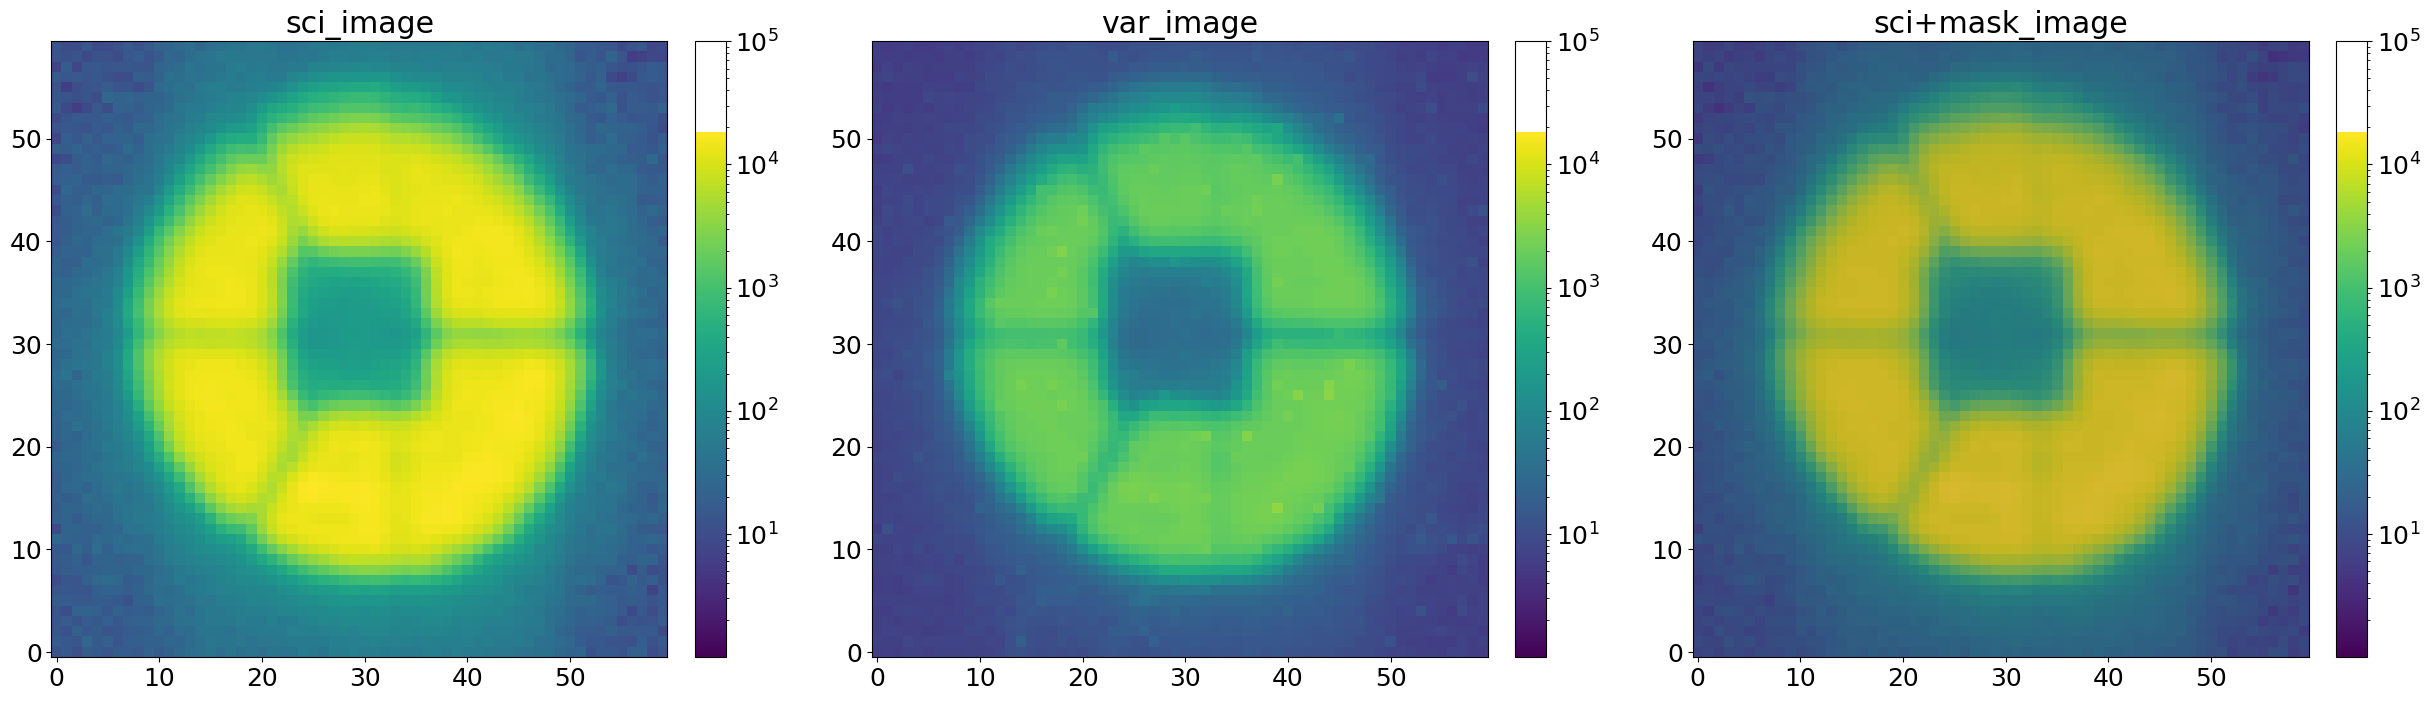

In [20]:
single_analysis=Zernike_Analysis(date=date,obs='m4',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
                                 list_of_defocuses=list_of_defocuses_input_short_with_focus)
single_analysis.create_basic_data_image()

In [21]:
double_sources,double_sources_positions_ratios=single_analysis.return_double_sources()
list_of_sci_images,list_of_var_images,list_of_mask_images=single_analysis.return_lists_of_images()
index_of_single_image=single_analysis.return_index_of_single_image_in_list_of_images()
columns,columns22,columns22_analysis=single_analysis.return_columns()


chain0_swarm_1,likechain0_swarm_1=single_analysis.create_chains_swarm_1()
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains_Emcee_2()
len_of_chains=single_analysis.len_of_chains()

minchain_parametrization,like_min=single_analysis.create_likelihood()

create_chains_swarm_1: Swarm1 and likechainSwarm1 found
Path searched was: /tigress/ncaplar/Results/chainSep0521_Single_P_34437558ArSwarm1.npy
create_chains_swarm_1: Swarm1 and likechainSwarm1 found
Path searched was: /tigress/ncaplar/Results/chainSep0521_Single_P_34437558ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 6.4754032204468155


### image analysis 

In [22]:
zmax_estimated = int((len(minchain_parametrization)-23)/2+3)
print('zmax number estimated from the size of minchain: ' + str(zmax_estimated))

zmax number estimated from the size of minchain: 56


In [23]:
DATAFRAMES_FOLDER='/tigress/ncaplar/PFS/Fit_Results/Apr1822/'

results_of_int_many_Ar_Apr1822=np.load(DATAFRAMES_FOLDER + 'results_of_fit_many_int_Ar_from_Apr1822.pkl',allow_pickle=True)
results_of_int_many_Ne_Apr1822=np.load(DATAFRAMES_FOLDER + 'results_of_fit_many_int_Ne_from_Apr1822.pkl',allow_pickle=True)
results_of_int_many_Kr_Apr1822=np.load(DATAFRAMES_FOLDER + 'results_of_fit_many_int_Kr_from_Apr1822.pkl',allow_pickle=True)

In [12]:
model_multi=LN_PFS_multi_same_spot(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,
                                   wavelength=wavelength,dithering=1,save=1,zmax=56,verbosity=1,\
            pupil_parameters=None,use_pupil_parameters=None,use_optPSF=None,list_of_wf_grid=None,\
            extraZernike=None,pupilExplicit=None,simulation_00=None,
            double_sources=double_sources,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,\
            list_of_defocuses=list_of_defocuses_input_long,fit_for_flux=True,test_run=False,list_of_psf_positions=None,
                                  use_center_of_flux=True)   


#minchain_parametrization_test=gbest[1]
#minchain_parametrization_test[0]=minchain_parametrization_test[0]+array_of_delta_z_parametrizations_None_1_0[0]

#minchain_parametrization_test=np.copy(allparameters_parametrization_proposal_initial+array_of_delta_all_parametrizations)

interpolation = False

if interpolation == False:
    list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=list_of_defocuses_input_short_with_focus,zmax=22)

    #res_multi=model_multi(list_of_minchain,return_Images=True)
    res_multi=model_multi(list_of_minchain,return_Images=True,use_only_chi=True)


    #res_multi_10=np.copy(res_multi)
    #res_multi_21=np.copy(res_multi)

    mean_res_of_multi_same_spot,list_of_single_res,list_of_single_model_image,\
                    list_of_single_allparameters,list_of_single_chi_results,array_of_psf_positions_output=res_multi
else:
    if arc=='Ar':
        list_of_minchain = [results_of_int_many_Ar_Apr1822['m4'].loc[int(single_number)][:-2].values,
                       results_of_int_many_Ar_Apr1822['0'].loc[int(single_number)][:-2].values,
                       results_of_int_many_Ar_Apr1822['p4'].loc[int(single_number)][:-2].values]
    if arc=='Ne':
        list_of_minchain = [results_of_int_many_Ne_Apr1822['m4'].loc[int(single_number)][:-2].values,
                       results_of_int_many_Ne_Apr1822['0'].loc[int(single_number)][:-2].values,
                       results_of_int_many_Ne_Apr1822['p4'].loc[int(single_number)][:-2].values]
    if arc=='Kr':
        list_of_minchain = [results_of_int_many_Kr_Apr1822['m4'].loc[int(single_number)][:-2].values,
                       results_of_int_many_Kr_Apr1822['0'].loc[int(single_number)][:-2].values,
                       results_of_int_many_Kr_Apr1822['p4'].loc[int(single_number)][:-2].values]
    
    res_multi=model_multi(list_of_minchain,return_Images=True,use_only_chi=True)


    #res_multi_10=np.copy(res_multi)
    #res_multi_21=np.copy(res_multi)

    mean_res_of_multi_same_spot,list_of_single_res,list_of_single_model_image,\
                    list_of_single_allparameters,list_of_single_chi_results,array_of_psf_positions_output=res_multi

In [13]:
popt_for_custom_var = create_popt_for_custom_var(sci_image=list_of_sci_images[index_of_single_image],
                            var_image=list_of_var_images[index_of_single_image],
                            mask_image=list_of_mask_images[index_of_single_image])
custom_var = create_custom_var_from_popt(model_image=list_of_single_model_image[index_of_single_image], popt = popt_for_custom_var)

In [14]:
list_of_var_images_via_model=[]
for index_of_single_image in range(len(list_of_sci_images)):
    
    popt_for_custom_var = create_popt_for_custom_var(sci_image=list_of_sci_images[index_of_single_image],
                            var_image=list_of_var_images[index_of_single_image],
                            mask_image=list_of_mask_images[index_of_single_image])
    single_var_image_via_model = create_custom_var_from_popt(model_image=list_of_single_model_image[index_of_single_image], popt = popt_for_custom_var)
   
    list_of_var_images_via_model.append(single_var_image_via_model)

In [15]:
use_only_chi=True


array_of_var_sum=np.array(list(map(np.sum,list_of_var_images)))
index_of_max_var_sum=np.where(array_of_var_sum==np.min(array_of_var_sum))[0][0]
# find what variance selectes top 20% of pixels
# this is done to weight more the images in focus and less the image out of focus in the 
# final likelihood result
quantile_08_focus=np.quantile(list_of_sci_images[index_of_max_var_sum],0.8)




list_of_var_sums=[]
for i in range(len(list_of_sci_images)):
    var_image_masked=list_of_var_images[i]
    sci_image=list_of_sci_images[i]
    

    mean_value_of_background=np.mean([np.median(var_image_masked[0]),np.median(var_image_masked[-1]),\
                          np.median(var_image_masked[:,0]),np.median(var_image_masked[:,-1])])*3
    #print(mean_value_of_background)
 
    #flux_mask=sci_image>(mean_value_of_background)
    #var_image_masked=var_image[flux_mask]
    
    var_image_masked_without_nan = var_image_masked.ravel()[var_image_masked.ravel()>quantile_08_focus]
    #print('number of pixels considering in image '+str(i)+': '+str(var_image_masked_without_nan.shape[0]))
    var_sum=-(1/2)*(np.sum(np.log(2*np.pi*var_image_masked_without_nan)))
    
    if use_only_chi==True:
        var_sum=-(1)*(np.mean(np.abs(var_image_masked_without_nan)))
    list_of_var_sums.append(var_sum)
    
array_of_var_sum=np.array(list_of_var_sums)
max_of_array_of_var_sum=np.max(array_of_var_sum)
print('array_of_var_sum '+str(array_of_var_sum))
renormalization_of_var_sum=array_of_var_sum/max_of_array_of_var_sum

renormalization_of_var_sum

array_of_var_sum=np.array(list(map(np.sum,list_of_var_images)))
index_of_max_var_sum=np.where(array_of_var_sum==np.min(array_of_var_sum))[0][0]
# find what variance selectes top 20% of pixels
# this is done to weight more the images in focus and less the image out of focus in the 
# final likelihood result

quantile_08_focus=np.quantile(list_of_sci_images[index_of_max_var_sum],0.8)
'model pixels with a flux larger than (quantile_08_focus): '+str(quantile_08_focus)

array_of_var_sum [-215.87121582 -127.20812225 -242.25369263]


'model pixels with a flux larger than (quantile_08_focus): 16.82285690307621'

mean reported value:-6.142086533741217
array_of_single_res: [-6.63251869 -4.57735519 -7.21638572]
renormalization factors: [1. 1. 1.]
array_of_single_res renormalized: [-6.63251869 -4.57735519 -7.21638572]


([<matplotlib.axis.XTick at 0x2b32323d0b80>,
 [Text(0, 0, 'm4'), Text(1, 0, '0'), Text(2, 0, 'p4')])

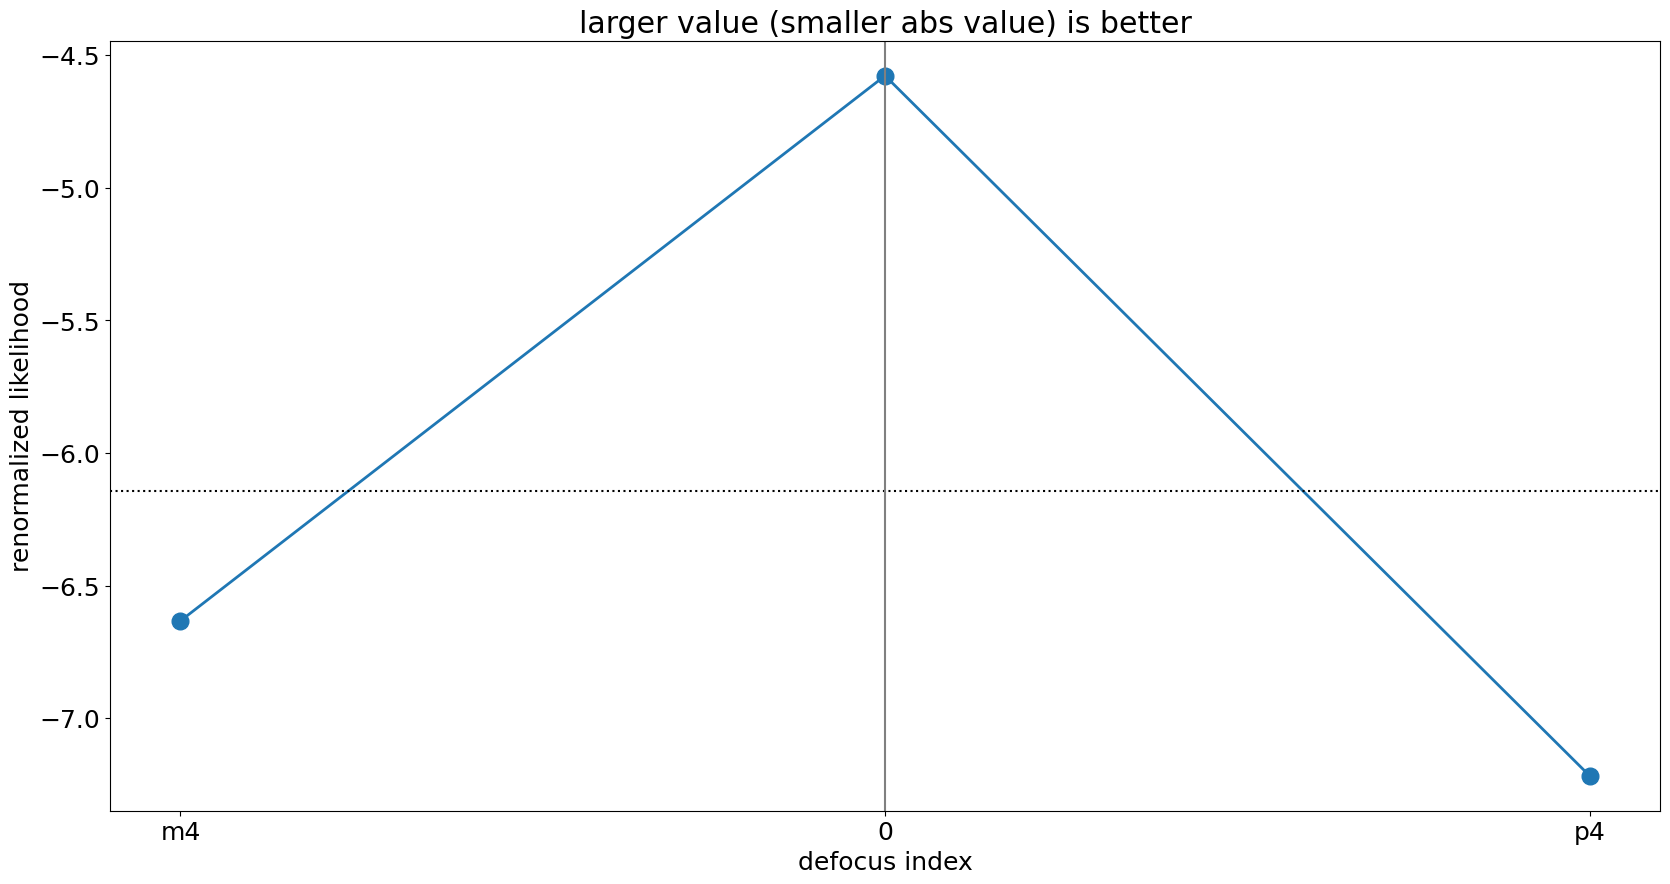

In [24]:
# shows the reported likelihood for each image, after division by the renormalization factor
# smaller absolute values is better
# dotted lien shows the mean reported value

plt.figure(figsize=(20,10))
array_of_single_res=np.array(list_of_single_res)


renormalization_of_var_sum=np.ones(len(list_of_sci_images))


mean_res_of_multi_same_spot=np.mean(array_of_single_res/renormalization_of_var_sum)
print('mean reported value:'+str(mean_res_of_multi_same_spot))
print('array_of_single_res: '+str(array_of_single_res))
print('renormalization factors: '+str(renormalization_of_var_sum))
print('array_of_single_res renormalized: '+str(array_of_single_res/renormalization_of_var_sum))
plt.plot(array_of_single_res/renormalization_of_var_sum,marker='o',lw=2,ms=12)
plt.xlabel('defocus index')
plt.ylabel('renormalized likelihood')
plt.axhline(mean_res_of_multi_same_spot,color='black',ls=":")
plt.title('larger value (smaller abs value) is better')

plt.axvline(np.where(np.array(list_of_defocuses_input_short_with_focus)=='0')[0][0],color='gray')
plt.xticks(np.arange(len(list_of_defocuses_input_short_with_focus)),list_of_defocuses_input_short_with_focus)

In [24]:
minchain=list_of_minchain[1]
#minchain[31] =0.937288
print('minchain.shape '+str(minchain.shape))

    
dfz11 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns22[0:8])
print(dfz11)
print('##############################################')
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][8:19]]),columns=columns22[8:19])
print(dfz22)

print('')
#dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][19:len(columns)]]),columns=columns[19:])
print('##############################################')
dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][19:19+6]]),columns=columns22[19:19+6])
print(dfglobal1)
print('##############################################')
dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][25:25+4]]),columns=columns22[25:25+4])
print(dfglobal2)
print('##############################################')
dfglobal3 = pd.DataFrame(np.array([np.array([minchain])[0][29:29+5]]),columns=columns22[29:29+5])
print(dfglobal3)
print('##############################################')
dfglobal4 = pd.DataFrame(np.array([np.array([minchain])[0][34:41]]),columns=columns22[34:41])
print(dfglobal4)

minchain.shape (42,)
         z4        z5        z6       z7        z8        z9       z10  \
0  0.179139 -0.733547 -0.422802 -0.31024  0.414465 -0.362545 -0.511088   

        z11  
0  0.503443  
##############################################
        z12       z13       z14       z15       z16       z17       z18  \
0  0.048085  0.179181 -0.031924  0.008576  0.056128  0.045181  0.022216   

        z19       z20       z21       z22  
0 -0.030397 -0.044897  0.020835  0.046362  

##############################################
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy
0  0.704435   0.100301 -0.211358  0.273418  0.063884     0.106733
##############################################
     wide_0   wide_23   wide_43  misalign
0  0.129209  0.268187  0.244579  1.128544
##############################################
    x_fiber   y_fiber  effective_radius_illumination  frd_sigma  \
0 -0.033611 -0.012692                       0.876423   0.030778   

   frd_lorentz_factor  

(-1.5, -0.5)

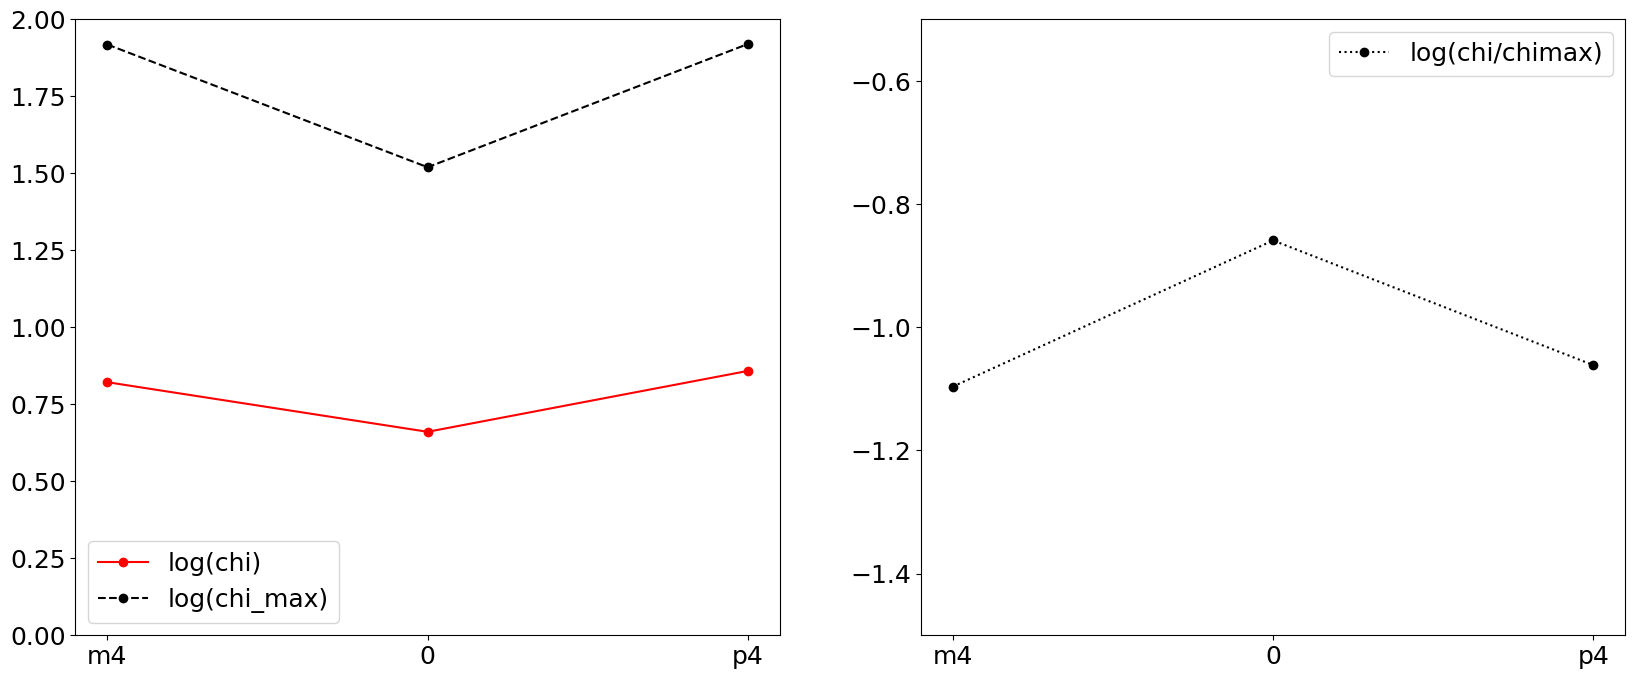

In [25]:
chi_results_array=np.array(res_multi[4])

plt.figure(figsize=(20,8))

plt.subplot(121)

plt.plot(np.log10(chi_results_array[:,2]),color='red',label='log(chi)',marker='o')
#plt.plot(np.log10(chi_results_array[:,3])-2.3,color='black',label='log(chi**2_max)-2.3',marker='o')
plt.plot(np.log10(chi_results_array[:,3]),color='black',label='log(chi_max)',marker='o',ls='--')
plt.ylim(0,2)
plt.xticks(np.arange(0,len(list_of_defocuses_input_short_with_focus),1),list_of_defocuses_input_short_with_focus)
plt.legend()
plt.subplot(122)

plt.plot(np.log10(chi_results_array[:,2]/chi_results_array[:,3]),color='black',label='log(chi/chimax)',marker='o',ls=':')
plt.legend()
plt.xticks(np.arange(0,len(list_of_defocuses_input_short_with_focus),1),list_of_defocuses_input_short_with_focus)
#plt.ylim(-2.8,-1.5)
plt.ylim(-1.5,-0.5)

3x mean_value_of_background via sci is estimated to be: 86.47214698791504
---------------------
chi**2 max reduced is: 6723.610725404958
chi**2 reduced is: 20123.082112420034 for log improvement: 0.4760919380454095
chi max reduced is: 48.502588088213486
chi reduced is: 90.87474494397398 for log improvement: 0.27267829185902837
---------------------
chi**2 reduced within custom mask area is: 20123.082120878502
---------------------
chi**2 max reduced within flux mask area is: 10904.418571598266
chi**2 reduced within flux mask area is: 33726.2425794198 for log improvement: 0.4903654456359405
chi max reduced within flux mask area is: 72.78287902245187
chi reduced within flux mask area is: 147.59934018205917 for log improvement: 0.3070551853720717
---------------------
Abs of residual divided by total flux is: 3.2562653606881127
Abs of residual divided by largest value of a flux in the image is: 3.7978489754244853


/tmp/ipykernel_162522/1758362394.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array_of_sci_image=np.array(list_of_sci_images)
/tmp/ipykernel_162522/1758362394.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array_of_single_model_image=np.array(list_of_single_model_image)
/tmp/ipykernel_162522/1758362394.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=

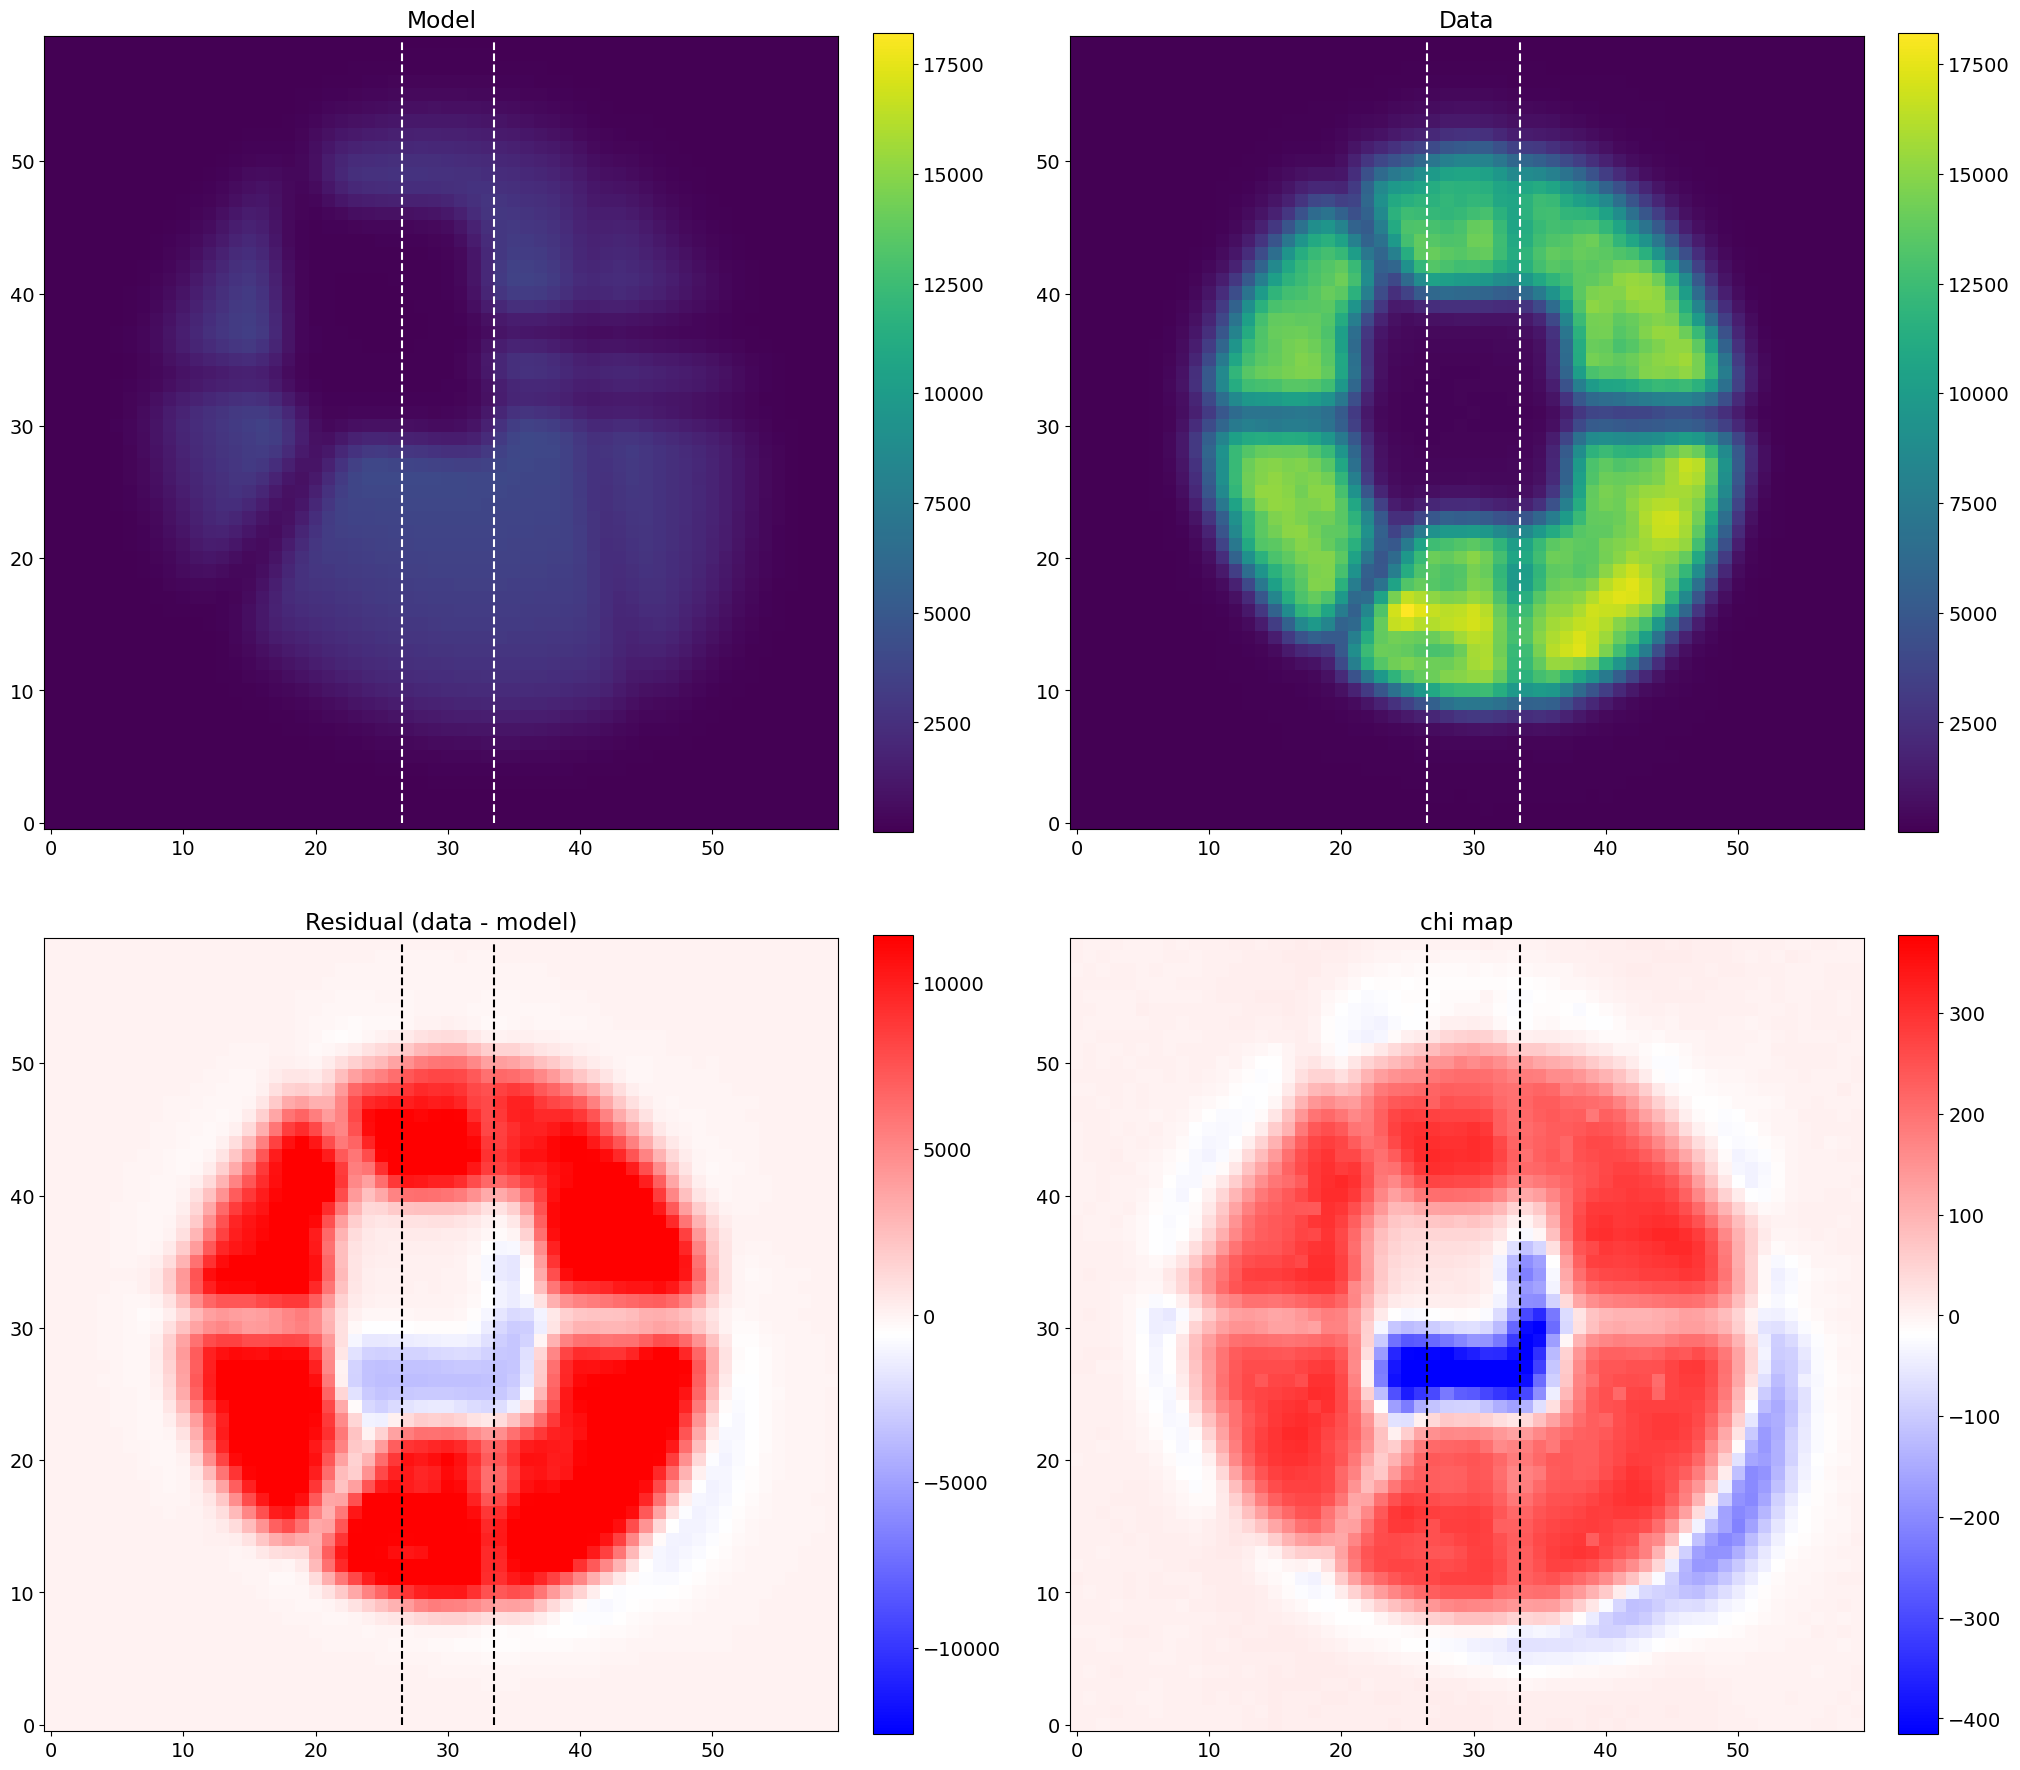

In [26]:
index_of_single_image=0

#
model_single_image = LN_PFS_single(list_of_sci_images[index_of_single_image],list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image],\
                                   dithering=1,save=0,zmax=56,verbosity=1,\
                                   double_sources=double_sources,double_sources_positions_ratios=double_sources_positions_ratios,fit_for_flux=True,npix=1536)

popt_for_custom_var = create_popt_for_custom_var(sci_image=list_of_sci_images[index_of_single_image],
                            var_image=list_of_var_images[index_of_single_image],
                            mask_image=list_of_mask_images[index_of_single_image])
custom_var = create_custom_var_from_popt(model_image=list_of_single_model_image[index_of_single_image], popt = popt_for_custom_var)

# custom_var=model_single_image.create_custom_var(modelImg=list_of_single_model_image[index_of_single_image],sci_image=list_of_sci_images[index_of_single_image],
#                                   var_image=list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image])

matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot(custom_model_image=list_of_single_model_image[index_of_single_image],\
                                             custom_mask=list_of_mask_images[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],\
                                             custom_var_image=list_of_var_images[index_of_single_image],\
                                             show_flux_mask=False,use_max_chi_scaling=True,use_max_flux_scaling=True,\
                                             show_impact_pixels_mask=False,multi_background_factor=3)

# I can move to use custom_var within the analysis
#single_analysis.create_basic_comparison_plot(custom_model_image=list_of_single_model_image[index_of_single_image],custom_mask=list_of_mask_images[index_of_single_image],\
#                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=custom_var,\
#                                             show_flux_mask=False,use_max_chi_scaling=True,use_max_flux_scaling=False)

array_of_sci_image=np.array(list_of_sci_images)
array_of_single_model_image=np.array(list_of_single_model_image)
array_of_var_images=np.array(list_of_var_images)
array_of_mask_images=np.array(list_of_mask_images)

3x mean_value_of_background via sci is estimated to be: 86.47214698791504
fraction of chi2 due to 1% of pixels: 0.06242572491735648
---------------------
chi**2 max reduced is: 6723.610725404958
chi**2 reduced is: 20123.082112420034 for log improvement: 0.4760919380454095
chi max reduced is: 48.502588088213486
chi reduced is: 90.87474494397398 for log improvement: 0.27267829185902837
---------------------
chi**2 reduced within custom mask area is: 20123.082120878502
---------------------
chi**2 max reduced within flux mask area is: 10904.418571598266
chi**2 reduced within flux mask area is: 33726.2425794198 for log improvement: 0.4903654456359405
chi max reduced within flux mask area is: 72.78287902245187
chi reduced within flux mask area is: 147.59934018205917 for log improvement: 0.3070551853720717
---------------------
Abs of residual divided by total flux is: 3.2562653606881127
Abs of residual divided by largest value of a flux in the image is: 3.7978489754244853


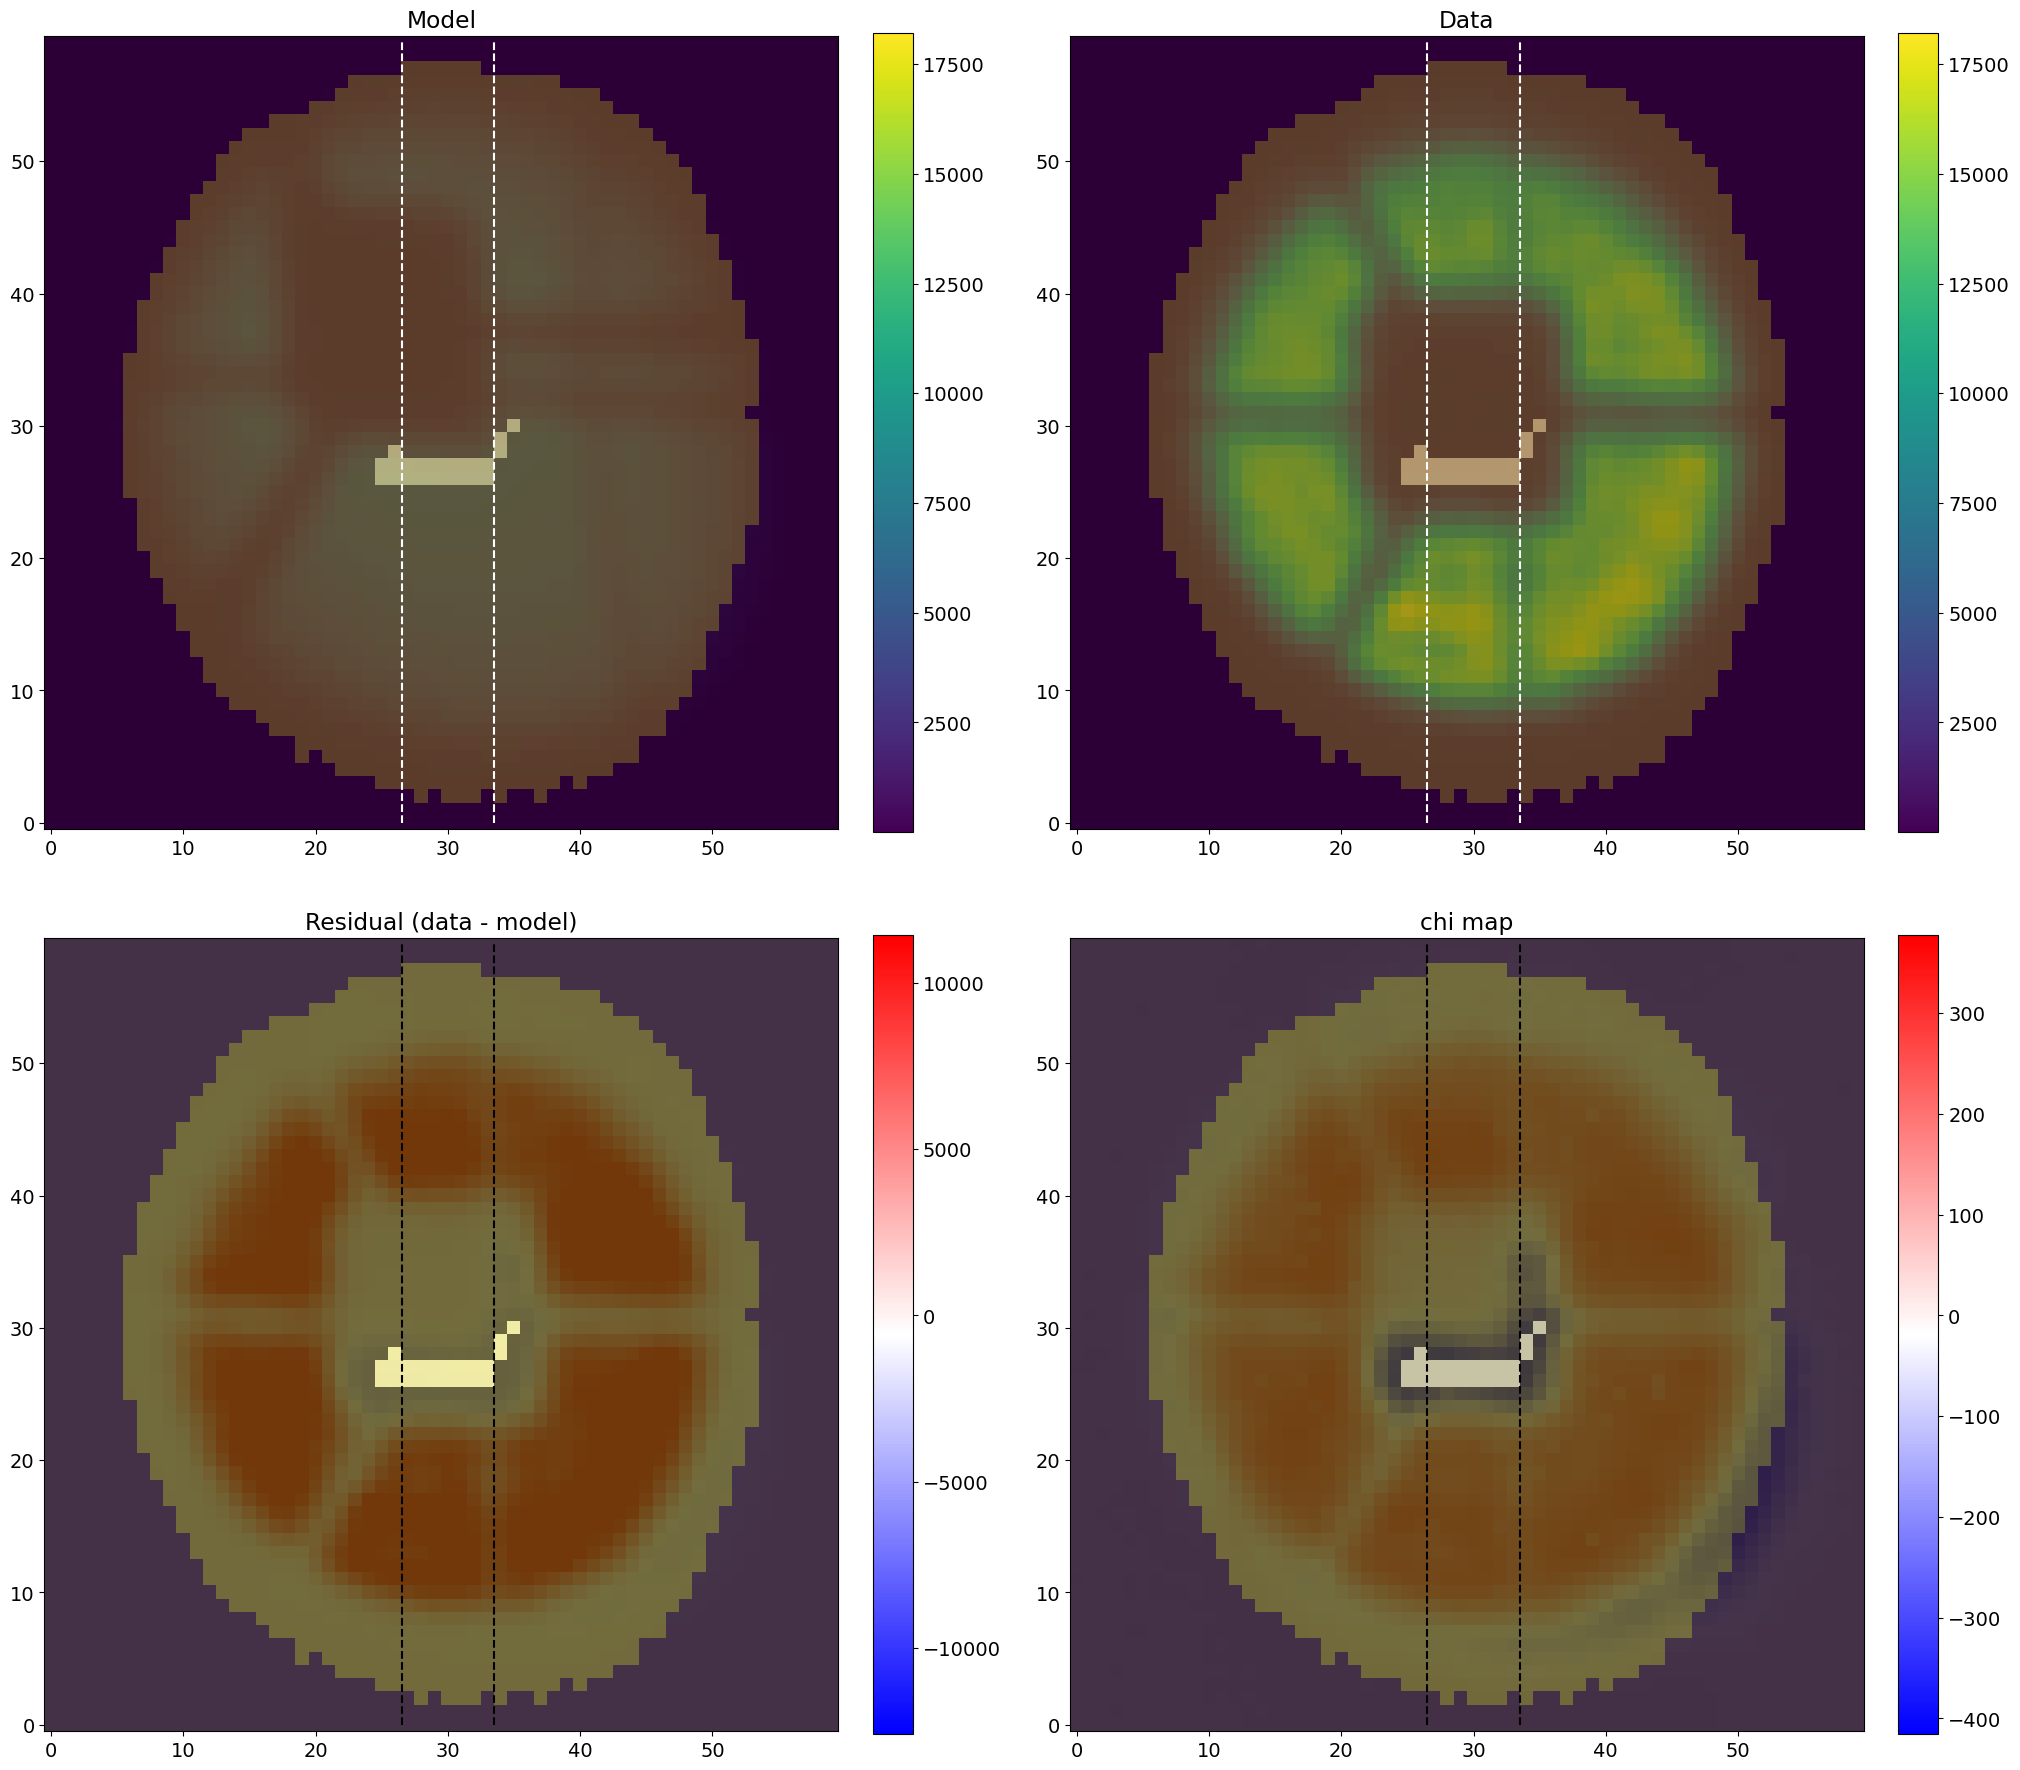

In [27]:
model_single_image = LN_PFS_single(list_of_sci_images[index_of_single_image],list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image],\
                                   dithering=1,save=0,zmax=56,verbosity=1,\
                                   double_sources=double_sources,double_sources_positions_ratios=double_sources_positions_ratios,fit_for_flux=True,npix=1536)

custom_var=model_single_image.create_custom_var(model_image=list_of_single_model_image[index_of_single_image],sci_image=list_of_sci_images[index_of_single_image],
                                    var_image=list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image])

matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot(custom_model_image=list_of_single_model_image[index_of_single_image],custom_mask=list_of_mask_images[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image],\
                                             show_flux_mask=True,use_max_chi_scaling=True,use_max_flux_scaling=True,show_impact_pixels_mask=True)

In [4]:
# Extra performance libraries for later
import numexpr
import numba
import numpy as np
import scipy
import scipy.fftpack

In [32]:
@numba.njit
def fft_custom_numba(expwf_grid):
    ftexpwf = np.fft.fftshift(scipy.fftpack.fft2(np.fft.fftshift(expwf_grid)))
    img_apod = np.abs(ftexpwf)**2
    return img_apod

In [27]:
def fft_custom(expwf_grid):
    ftexpwf = np.fft.fftshift(scipy.fftpack.fft2(np.fft.fftshift(expwf_grid)))
    img_apod = np.abs(ftexpwf)**2
    return img_apod

In [14]:
expwf_grid = np.load('/tigress/ncaplar/Testing/Wavefront_Images/expwf_grid.npy')

In [16]:
%timeit ftexpwf = np.fft.fftshift(scipy.fftpack.fft2(np.fft.fftshift(expwf_grid))); img_apod = np.abs(ftexpwf)**2

1 loop, best of 3: 463 ms per loop


In [33]:
fft_custom_numba(expwf_grid)

TypingError: Failed at nopython (nopython frontend)
[1m[1mUnknown attribute 'fftshift' of type Module(<module 'numpy.fft' from '/usr/licensed/anaconda/5.3.1/lib/python2.7/site-packages/numpy/fft/__init__.pyc'>)
[1m
File "<ipython-input-32-37ac58fde9a7>", line 3:[0m
[1mdef fft_custom_numba(expwf_grid):
[1m    ftexpwf = np.fft.fftshift(scipy.fftpack.fft2(np.fft.fftshift(expwf_grid)))
[0m    [1m^[0m[0m
[0m
[0m[1m[1] During: typing of get attribute at <ipython-input-32-37ac58fde9a7> (3)[0m
[1m
File "<ipython-input-32-37ac58fde9a7>", line 3:[0m
[1mdef fft_custom_numba(expwf_grid):
[1m    ftexpwf = np.fft.fftshift(scipy.fftpack.fft2(np.fft.fftshift(expwf_grid)))
[0m    [1m^[0m[0m

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [24]:
fft_custom(expwf_grid)

array([[0.20930655, 0.56966305, 0.40827057, ..., 0.0661767 , 0.00780152,
        0.01203255],
       [0.12991406, 0.3658852 , 0.45571387, ..., 0.12254926, 0.08383492,
        0.15257138],
       [0.03771545, 0.02017954, 0.13220918, ..., 0.0712605 , 0.06472878,
        0.146585  ],
       ...,
       [0.10367034, 0.07113148, 0.07065199, ..., 0.508572  , 0.2316218 ,
        0.00209333],
       [0.15333319, 0.11189505, 0.19537419, ..., 0.42568022, 0.36742148,
        0.09392266],
       [0.1623453 , 0.06997858, 0.0654541 , ..., 0.02911485, 0.10730913,
        0.1577881 ]], dtype=float32)

In [26]:
import lmfit
from scipy.linalg import svd
from scipy import signal
from scipy.ndimage.filters import gaussian_filter
import scipy.fftpack
import scipy.misc
from scipy.special import erf
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import Tophat2DKernel
import lsst.afw.math
import lsst.afw.image
import lsst.afw
import lsst
import galsim
import traceback

In [19]:
import time

In [20]:
sci_image = np.load('/tigress/ncaplar/Testing/Final_Images/sci_image.npy')
var_image = np.load('/tigress/ncaplar/Testing/Final_Images/var_image.npy')
mask_image = np.load('/tigress/ncaplar/Testing/Final_Images/mask_image.npy')
optPsf_cut_grating_convolved = np.load('/tigress/ncaplar/Testing/Final_Images/optPsf_cut_grating_convolved.npy')

In [21]:
oversampling=11    
shape=(60,60)
single_Psf_position = Psf_position(optPsf_cut_grating_convolved,
                                      int(round(oversampling)),
                                      shape[0],
                                      simulation_00=None,
                                      verbosity=1,
                                      save=False)

In [22]:

def find_centroid_of_flux(image, mask=None):
    """
    function giving the tuple of the position of weighted average of the flux in a square image
    indentical result as calculateCentroid from drp_stella.images

    @input image    poststamp image for which to find center
    @input mask     mask, same size as the image

    returns tuple with x and y center, in units of pixels
    """
    if mask is None:
        mask = np.ones(image.shape)

    x_center = []
    y_center = []

    # if there are nan values (most likely cosmics), replace them with max value in the rest of the image
    # careful, this can seriously skew the results if not used for this purpose
    max_value_image = np.max(image[~np.isnan(image)])
    image[np.isnan(image)] = max_value_image

    I_x = []
    for i in range(len(image)):
        I_x.append([i, np.mean(image[:, i] * mask[:, i])])

    I_x = np.array(I_x)

    I_y = []
    for i in range(len(image)):
        I_y.append([i, np.mean(image[i] * mask[i])])

    I_y = np.array(I_y)

    x_center = (np.sum(I_x[:, 0] * I_x[:, 1]) / np.sum(I_x[:, 1]))
    y_center = (np.sum(I_y[:, 0] * I_y[:, 1]) / np.sum(I_y[:, 1]))

    return(x_center, y_center)

In [29]:
#  run the code for centering
time_start_single = time.time()
optPsf_final, psf_position =\
    single_Psf_position.find_single_realization_min_cut(optPsf_cut_grating_convolved,
                                                        int(round(oversampling)),
                                                        shape[0],
                                                        sci_image,
                                                        var_image,
                                                        mask_image,
                                                        v_flux=1,
                                                        double_sources=None,
                                                        double_sources_positions_ratios= #noqa: E251
                                                        [0,0],
                                                        verbosity=True,
                                                        explicit_psf_position= #noqa: E251
                                                        None,
                                                        use_only_chi=True,
                                                        use_center_of_flux=False)
time_end_single = time.time()

print(time_end_single - time_start_single)

parameter use_only_chi in Psf_postion is set to: True
parameter use_center_of_flux in Psf_postion is set to: False
parameter simulation_00 in Psf_postion is set to: None
[0, 0, 0, 0]
time_2-time_1 for initial_complete_realization: 0.16219019889831543
centroid_of_initial_complete_realization (28.34060404567905, 33.00755613099532)
centroid_of_sci_image (31.527127463478333, 27.336303229787813)
offset_initial_and_sci: [ 3.18652342 -5.6712529 ]
[x_primary, y_primary, y_secondary,ratio_secondary] / chi2 output
[ 24.0517576  -84.38378191]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 24.0517576  -84.38378191] / 105.49994944378113
[ 35.0517576  -62.38378191]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 35.0517576  -62.38378191] / 96.99316687733169
[ 40.5517576  -73.38378191]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 40.5517576  -73.38378191] / 101.00962048467116
[ 29.5517576  -51.38378191]
chi2 within shgo with 

chi2 within shgo with use_only_chi True and use_center_of_light False [ 6.61492991 27.13285347] / 79.6287861539757
[10.97087615  3.57696193]
chi2 within shgo with use_only_chi True and use_center_of_light False [10.97087615  3.57696193] / 79.21879630060769
[0.66360361 2.74089145]
chi2 within shgo with use_only_chi True and use_center_of_light False [0.66360361 2.74089145] / 79.68108227376858
[11.17029865  9.57044363]
chi2 within shgo with use_only_chi True and use_center_of_light False [11.17029865  9.57044363] / 79.05322331915623
[ 4.5646803  17.00437223]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 4.5646803  17.00437223] / 78.97949719987085
[ 1.36158238 23.71807738]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 1.36158238 23.71807738] / 79.49599074874217
[-2.24036055 18.44481914]
chi2 within shgo with use_only_chi True and use_center_of_light False [-2.24036055 18.44481914] / 79.533378496733
[ 7.81763385 11.78903751]
chi2 within s

chi2 within shgo with use_only_chi True and use_center_of_light False [ 8.13693538 14.45312554] / 78.9378099976856
[ 8.13612632 14.45312236]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 8.13612632 14.45312236] / 78.9378085513684
[ 8.13648293 14.45463671]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 8.13648293 14.45463671] / 78.93781073160204
[ 8.13547494 14.45293068]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 8.13547494 14.45293068] / 78.93780877075467
[ 8.13614693 14.45406804]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 8.13614693 14.45406804] / 78.93780955790332
[ 8.13564294 14.45321502]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 8.13564294 14.45321502] / 78.93780829765134
[ 8.13501218 14.45396901]
chi2 within shgo with use_only_chi True and use_center_of_light False [ 8.13501218 14.45396901] / 78.93780807558073
[ 8.13445511 14.45439234]
chi2 wit

In [32]:
%timeit single_Psf_position.create_complete_realization([0.02,0,0,0])

[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]


chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
[0.02, 0, 0, 0]
chi2 within shgo

In [34]:
%lprun -f single_Psf_position.create_complete_realization([0.02,0,0,0])

UsageError: Line magic function `%lprun` not found.


In [35]:
import cProfile

In [36]:
cProfile.run("single_Psf_position.create_complete_realization([0.02,0,0,0])", sort=2)

[0.02, 0, 0, 0]
chi2 within shgo with use_only_chi False and use_center_of_light False [0.02, 0, 0, 0] / 38312.90044020858
         321 function calls in 0.021 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.021    0.021 {built-in method builtins.exec}
        1    0.001    0.001    0.021    0.021 <string>:1(<module>)
        1    0.000    0.000    0.020    0.020 121828719.py:564(create_complete_realization)
        1    0.014    0.014    0.014    0.014 {built-in method lsst.afw.math.offsetImage.offsetImage}
        1    0.000    0.000    0.004    0.004 Zernike_Analysis_Module.py:3290(resize)
        2    0.000    0.000    0.003    0.002 numeric.py:1210(tensordot)
        2    0.003    0.002    0.003    0.002 {built-in method numpy.dot}
        2    0.000    0.000    0.001    0.001 Zernike_Analysis_Module.py:3266(_resize_weights)
        2    0.001    0.000    0.001    0.000 Zernike_Analys

In [50]:
from Zernike_Module import ZernikeFitterPFS

In [51]:
>>> zmax = 22
>>> single_image_analysis = ZernikeFitterPFS(zmaxInit = zmax,
                                             verbosity=1)
>>> single_image_analysis.initParams()

pixelScale20.76
diam_sic0.1395327
np.__version__1.16.2
scipy.__version__1.5.2
 
Initializing ZernikeFitterPFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 22


In [56]:
single_image_analysis.params

Parameters([('z4', <Parameter 'z4', 0.0, bounds=[-inf:inf]>),
            ('z5', <Parameter 'z5', 0.0, bounds=[-inf:inf]>),
            ('z6', <Parameter 'z6', 0.0, bounds=[-inf:inf]>),
            ('z7', <Parameter 'z7', 0.0, bounds=[-inf:inf]>),
            ('z8', <Parameter 'z8', 0.0, bounds=[-inf:inf]>),
            ('z9', <Parameter 'z9', 0.0, bounds=[-inf:inf]>),
            ('z10', <Parameter 'z10', 0.0, bounds=[-inf:inf]>),
            ('z11', <Parameter 'z11', 0.0, bounds=[-inf:inf]>),
            ('z12', <Parameter 'z12', 0.0, bounds=[-inf:inf]>),
            ('z13', <Parameter 'z13', 0.0, bounds=[-inf:inf]>),
            ('z14', <Parameter 'z14', 0.0, bounds=[-inf:inf]>),
            ('z15', <Parameter 'z15', 0.0, bounds=[-inf:inf]>),
            ('z16', <Parameter 'z16', 0.0, bounds=[-inf:inf]>),
            ('z17', <Parameter 'z17', 0.0, bounds=[-inf:inf]>),
            ('z18', <Parameter 'z18', 0.0, bounds=[-inf:inf]>),
            ('z19', <Parameter 'z19', 0.0, bounds=[-

In [3]:

import logging

#50 CRITICAL
#40 ERROR
#30 WARNING <-- default
#20 INFO
#10 DEBUG
# 0 NOTSET 

# option - set a basic config for root logger and its descendents
#logging.basicConfig(level=logging.DEBUG)
#logger = logging.getLogger('b')
#logger.setLevel(logging.DEBUG)

# option = create a handler for this logger
handler = logging.StreamHandler()
handler.setLevel(logging.DEBUG)
logger.addHandler(handler)

print('log level', logger.getEffectiveLevel())
logger.debug('1') # 10
logger.info('2') # 20
logger.warning('3') # 30
logger.error('4') # 4

NameError: name 'logger' is not defined

In [9]:
%load_ext autoreload
%autoreload 2
logging.basicConfig(filename='/home/ncaplar/logs/app.log', filemode='w', format='%(name)s - %(levelname)s - %(message)s')
logging.debug('This will get logged')

DEBUG:root:This will get logged


In [1]:
import logging
logging.basicConfig(filename='/home/ncaplar/logs/app.log', filemode='w', level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logging.debug('This will get logged')

In [2]:
import ics

ModuleNotFoundError: No module named 'ics'

In [1]:
from ics.cobraCharmer import pfiDesign

pfi = pfiDesign.PFIDesign(fileName=
pathlib.Path(
    '/software/devel/cpl/pfs_instdata/data/pfi/modules/ALL/ALL_final_20210920_mm.xml'))

disabledOrBrokenCobras = pfi.status != pfi.COBRA_OK_MASK

ModuleNotFoundError: No module named 'ics'

# Zemax wavefront recreation?

In [ ]:
# http://localhost:8888/notebooks/Documents/PFS/PFS_Work_In_Progress/Zernike_Work_Jul_Aug.ipynb
# PIPE2D - 443

#/Users/nevencaplar/Documents/PFS/FromZemax/July18/Wave_11_Field_12_Z4_positive_wavefront.txt

[23.45906811, -0.66484436, 0.00750100, -0.44849033, -0.06596768, -0.04424084, -0.38955272, -0.59585152,
-0.00179066, 0.20827259, 0.05517687, -0.00846765, -0.02191191, 0.05790115, 0.01605635, 0.02580918, 0.01169519, -0.01007352, -0.00567526]

#Z   4	   23.45906811	:	   3^(1/2) (2p^2 - 1)
Z   5	   -0.66484436	:	   6^(1/2) (p^2) * SIN (2A)
Z   6	    0.00750100	:	   6^(1/2) (p^2) * COS (2A)
Z   7	   -0.44849033	:	   8^(1/2) (3p^3 - 2p) * SIN (A)
Z   8	   -0.06596768	:	   8^(1/2) (3p^3 - 2p) * COS (A)
Z   9	   -0.04424084	:	   8^(1/2) (p^3) * SIN (3A)
Z  10	   -0.38955272	:	   8^(1/2) (p^3) * COS (3A)
Z  11	   -0.59585152	:	   5^(1/2) (6p^4 - 6p^2 + 1)
Z  12	   -0.00179066	:	  10^(1/2) (4p^4 - 3p^2) * COS (2A)
Z  13	    0.20827259	:	  10^(1/2) (4p^4 - 3p^2) * SIN (2A)
Z  14	    0.05517687	:	  10^(1/2) (p^4) * COS (4A)
Z  15	   -0.00846765	:	  10^(1/2) (p^4) * SIN (4A)
Z  16	   -0.02191191	:	  12^(1/2) (10p^5 - 12p^3 + 3p) * COS (A)
Z  17	    0.05790115	:	  12^(1/2) (10p^5 - 12p^3 + 3p) * SIN (A)
Z  18	    0.01605635	:	  12^(1/2) (5p^5 - 4p^3) * COS (3A)
Z  19	    0.02580918	:	  12^(1/2) (5p^5 - 4p^3) * SIN (3A)
Z  20	    0.01169519	:	  12^(1/2) (p^5) * COS (5A)
Z  21	   -0.01007352	:	  12^(1/2) (p^5) * SIN (5A)
Z  22	   -0.00567526	:	   7^(1/2) (20p^6 - 30p^4 + 12p^2 - 1)

In [6]:
sci_image_unit=np.ones((60,60))
var_image_unit=np.ones((60,60))

In [7]:
allparameters_proposal0 = results_of_fit_many_Ar_Sep0521['m4'].loc['11'].values

In [8]:
allparameters_proposal = [23.45906811, -0.66484436, 0.00750100, -0.44849033, -0.06596768, -0.04424084, -0.38955272, -0.59585152,
-0.00179066, 0.20827259, 0.05517687, -0.00846765, -0.02191191, 0.05790115, 0.01605635, 0.02580918, 0.01169519, -0.01007352, -0.00567526]

allparameters_proposal_23_56 = [0.03523945, -0.00175281, -0.00054785, 0.01979506, -0.00514938, 0.00028577, 0.00463694, -0.02322185, 0.01812128, 0.01933662, -0.00820100,
                               0.00973798, -0.00176273, 0.00197307, -0.01721404, -0.00414606, 0.03123680, 0.01651019, -0.00043616, 0.00068183, -0.00419010,
                               0.00103857, 0.00223857,  -0.01956554, 0.00738963, 0.02009390, 0.01497587, 0.00843032, -0.00724961, 0.00236608, -0.00125791,
                               0.00029718, -0.00049355, -0.00931813 ]

In [34]:
allparameters_proposal_Robert_B = [24.58503263, -0.68425902, 0.01991284, -0.34572978, 0.01212449, -0.08099064, -0.37243158, -0.64678126,
0.00348469, 0.27223588, 0.06398808, 0.01311554, -0.08232472, 0.01977956, 0.03430799, 0.04807165, 0.03241732,  0.00921495, 0.01853263]

allparameters_proposal_23_56_Robert_B = [0.02943959, -0.00500733, 0.01816771, 0.01957312, -0.00717914, 0.01188538, 0.03377916, 0.01633137, 0.00857649, 0.04263265, 0.01059696,
                               0.02423739, -0.00071035, -0.00067159, -0.00701669,  0.01637885, 0.08590382, 0.02170847,0.01357395 0.00904485, -0.00424710,
                               -0.00276453, 0.00222828, -0.02322572, -0.00519767, 0.02516111,  0.03332592,  0.01956731,0.01527569,-0.00064242,  0.00138662,
                               0.00029718,-0.00205295 -0.00931813 ]

SyntaxError: invalid syntax (3692370198.py, line 5)

In [9]:
columns = [
'z4',
'z5',
'z6',
'z7',
'z8',
'z9',
'z10',
'z11',
'z12',
'z13',
'z14',
'z15',
'z16',
'z17',
'z18',
'z19',
'z20',
'z21',
'z22',
'detFrac',
'strutFrac',
'dxFocal',
'dyFocal',
'slitFrac',
'slitFrac_dy',
'wide_0',
'wide_23',
'wide_43',
'misalign',
'x_fiber',
'y_fiber',
'effective_ilum_radius',
'frd_sigma',
'frd_lorentz_factor',
'det_vert',
'slitHolder_frac_dx',
'grating_lines',
'scattering_slope',
'scattering_amplitude',
'pixel_effect',
'fiber_r',
'flux']

In [10]:
allparameters_proposal1 = np.copy(allparameters_proposal0)[:-2]
allparameters_proposal1[0:len(allparameters_proposal)] = allparameters_proposal 
allparameters_proposal1[-len(allparameters_proposal_23_56):] = allparameters_proposal_23_56
allparameters_proposal1[31] = 1 

"""
allparameters_proposal1 = np.copy(allparameters_proposal0)[:-2]
allparameters_proposal1[0:len(allparameters_proposal)] = allparameters_proposal_Robert_B 
allparameters_proposal1[-len(allparameters_proposal_23_56):] = allparameters_proposal_23_56_Robert_B
allparameters_proposal1[31] = 1 
"""
#allparameters_proposal1[29] = 0 
#allparameters_proposal1[30] = 0 
#allparameters_proposal1[21] = 0 
#allparameters_proposal1[22] = 0 

'\nallparameters_proposal1 = np.copy(allparameters_proposal0)[:-2]\nallparameters_proposal1[0:len(allparameters_proposal)] = allparameters_proposal_Robert_B \nallparameters_proposal1[-len(allparameters_proposal_23_56):] = allparameters_proposal_23_56_Robert_B\nallparameters_proposal1[31] = 1 \n'

In [11]:
model_single_image = LN_PFS_single(sci_image_unit,var_image_unit,mask_image=None,
                                   dithering=1,save=1,zmax=56,verbosity=1,
                                   fit_for_flux=True,npix=1536,wavelength=970)

In [12]:
res=model_single_image(allparameters_proposal1,return_Image=True)

res_iapetus=res[1]

1


/projects/HSC/PFS/stack/20220525/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [27]:
import socket
socket.gethostname()

'tiger2-sumire.princeton.edu'

In [14]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
#radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')


/tmp/ipykernel_148053/881911271.py:10: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar()


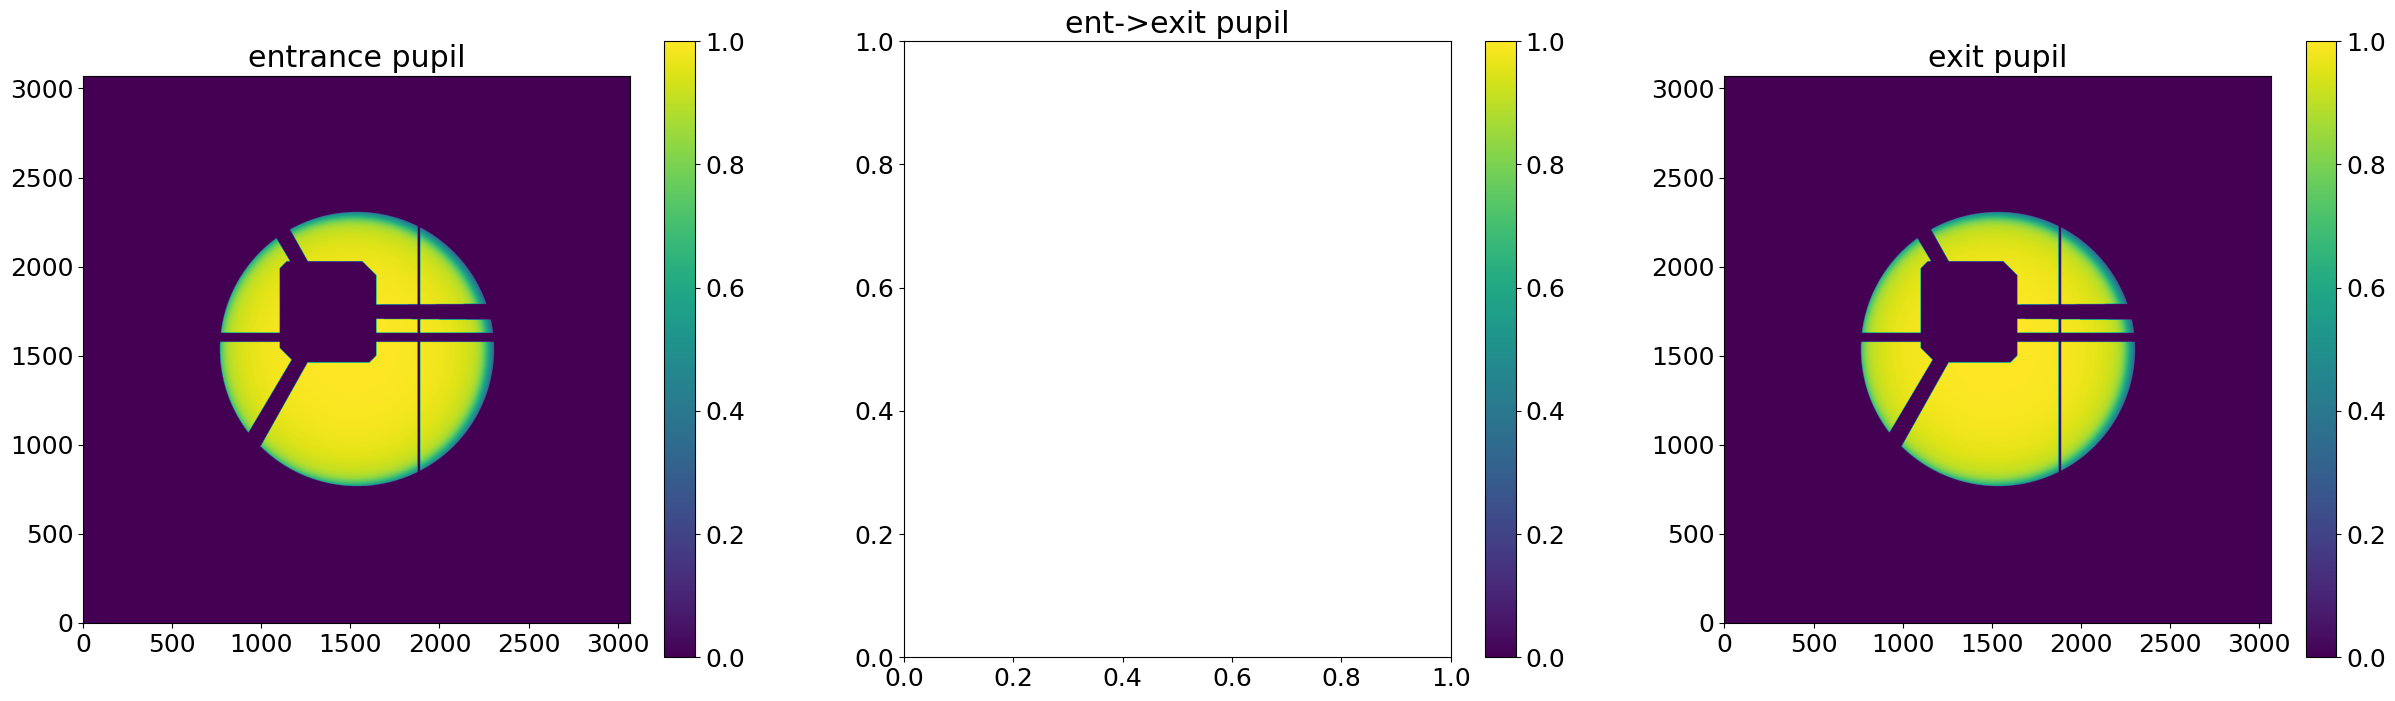

In [15]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
#plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

Text(0.5, 1.0, 'Zemax model, upper left corner')

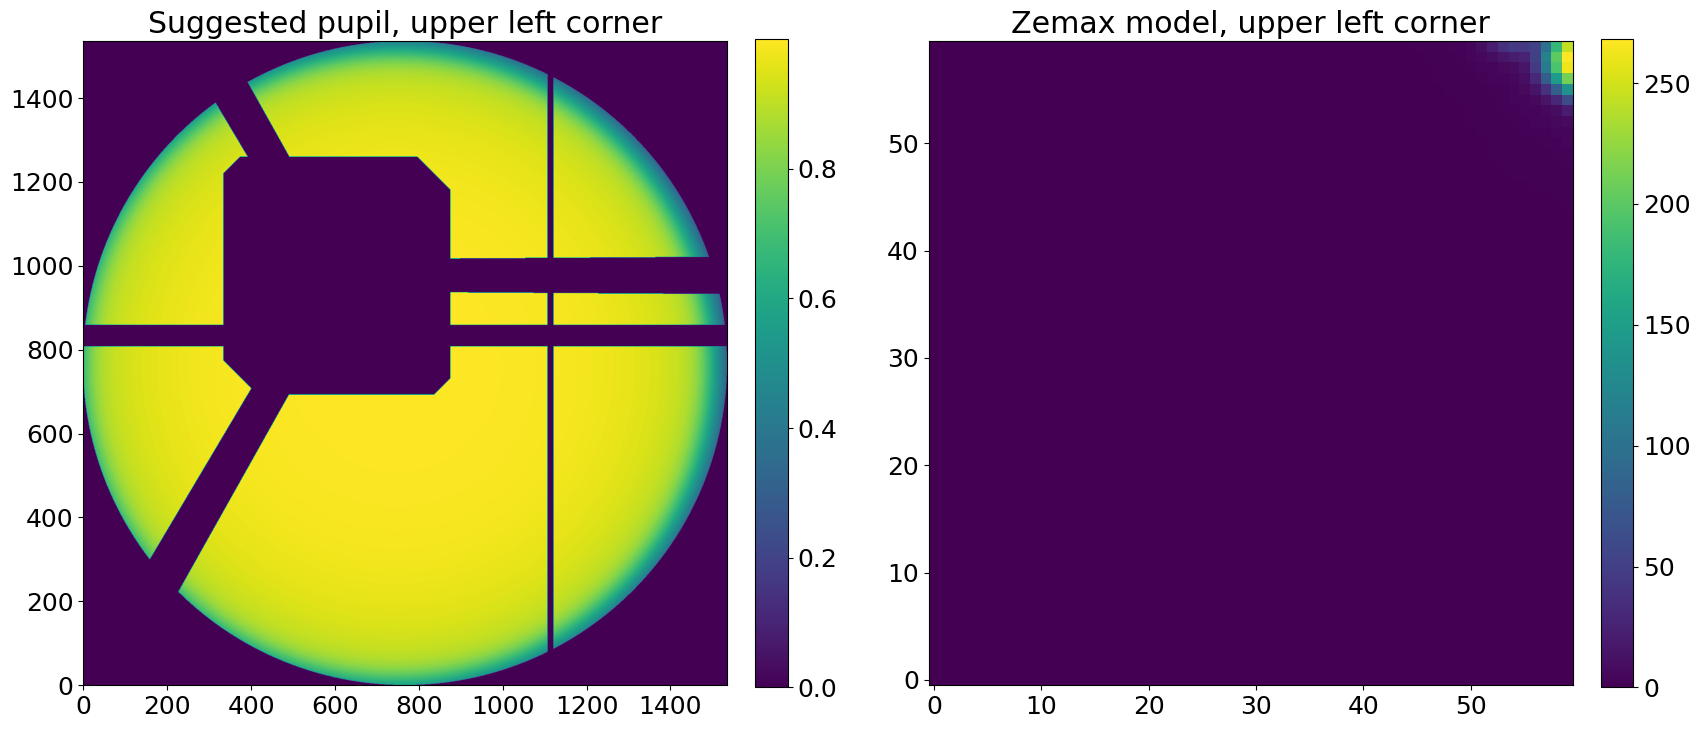

In [16]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Suggested pupil, upper left corner')

plt.subplot(122)
plt.imshow(res_iapetus,origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Zemax model, upper left corner')

In [17]:
import logging
from IPython.display import display, HTML

class DisplayHandler(logging.Handler):
    def emit(self, record):
        message = self.format(record)
        display(message)

In [49]:
class HTMLFormatter(logging.Formatter):
    level_colors = {
        logging.DEBUG: 'lightblue',
        logging.INFO: 'dodgerblue',
        logging.WARNING: 'goldenrod',
        logging.ERROR: 'crimson',
        logging.CRITICAL: 'firebrick'
    }
    
    def __init__(self):
        super().__init__(
            '<span style="font-weight: bold; color: green">{asctime}</span> '
            '[<span style="font-weight: bold; color: {levelcolor}">{levelname}</span>] '
            '{message}',
            style='{'
        )
    
    def format(self, record):
        record.levelcolor = self.level_colors.get(record.levelno, 'black')
        return HTML(super().format(record))

In [52]:
log = logging.getLogger()
handler = DisplayHandler()
handler.setFormatter(HTMLFormatter())
log.addHandler(handler)
log.setLevel(logging.DEBUG)

In [53]:
logging.info('Hello world!')

INFO:root:Hello world!


In [18]:
optPsf_cut=np.load('/tigress/ncaplar/PFS/Testing/Final_Images/'+'optPsf_cut.npy')
optPsf_cut_downsampled = np.load('/tigress/ncaplar/PFS/Testing/Final_Images/'+'optPsf_cut_downsampled.npy')

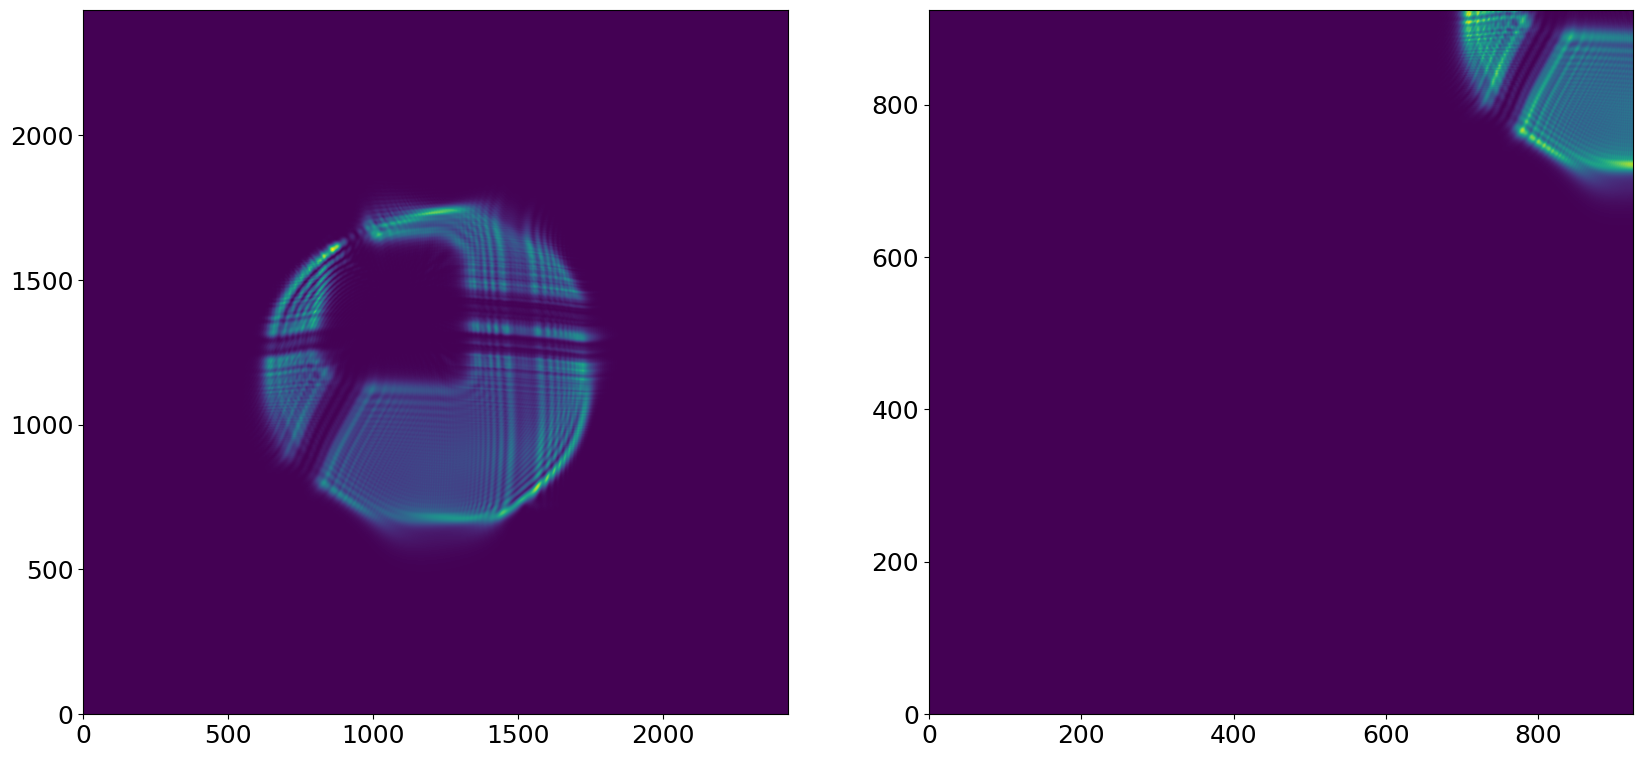

In [22]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(optPsf_cut, origin = 'lower')

plt.subplot(122)
plt.imshow(optPsf_cut_downsampled, origin = 'lower')

In [29]:
"""
INFO:root:Value of oversampling_original: 28.955860484616228
2022-05-26 17:49:14,965 [INFO] Value of oversampling_original: 28.955860484616228
INFO:root:size_of_central_cut: 2432
2022-05-26 17:49:14,966 [INFO] size_of_central_cut: 2432
INFO:root:optPsf_cut.shape(2433, 2433)
2022-05-26 17:49:14,967 [INFO] optPsf_cut.shape(2433, 2433)
INFO:root:oversampling:11
2022-05-26 17:49:14,968 [INFO] oversampling:11
INFO:root:size_of_optPsf_cut_downsampled: 924
2022-05-26 17:49:14,970 [INFO] size_of_optPsf_cut_downsampled: 924

"""

print(galsim.__version__)
oversampling_original = 28.955860484616228
oversampling = 11
size_of_optPsf_cut_downsampled = 924

2.3.4


In [34]:
im1 = galsim.Image(optPsf_cut, copy=True, scale=1)
interpolated_image = galsim.InterpolatedImage(im1, x_interpolant=galsim.Lanczos(5, True))
optPsf_cut_downsampled_manual = interpolated_image.\
    drawImage(nx=size_of_optPsf_cut_downsampled, ny=size_of_optPsf_cut_downsampled,
              scale=(oversampling_original / oversampling), method='no_pixel', use_true_center = False).array

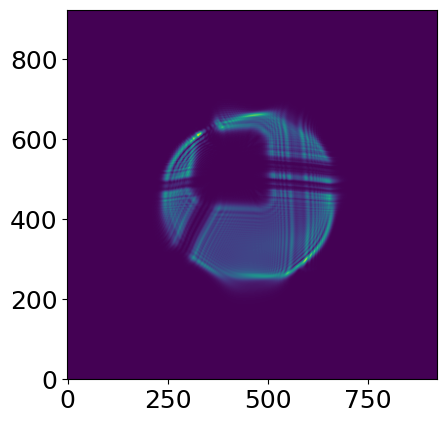

In [35]:
plt.imshow(optPsf_cut_downsampled_manual, origin = 'lower')

'2.3.4'